## Solar project - in progress

### 1. Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from datetime import datetime

### 2. Data Loading

In [4]:
# Loading data

generation = pd.read_csv('Plant_1_Generation_Data.csv', sep=';')
weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

Datas for the first week of June was mistakenly interpreted by to_datetime: day was replaced by month and vice versa. There was a necesity to define which of them is first, like below.

At first let's see the amount of produced energy over a given period of time. To this there is necesity to convert power to energy - in this case to divide it by 4. The amount of energy will be cumulated for days.

In [5]:
sum_gen = generation.groupby(['DATE_TIME'], sort=False).sum().reset_index()
sum_gen['DATE_TIME'] = pd.to_datetime(sum_gen['DATE_TIME'])
weather['DATE_TIME'] = pd.to_datetime(weather['DATE_TIME'])
sum_gen.drop(columns=['PLANT_ID'], inplace=True)

### 3. Preparing DataFrame

Sumarized data of all inverters was merged in one DataFrame with weather data, like below.

To calculate the amount of produced energy there is a necesity to calculate 1 hour data stamp, not 15 minutes one, because we need to calculate energy unit 1 kWh which is 1 kW (power unit) per hour.

In [6]:
sum_gen['ENERGY'] = sum_gen['AC_POWER']/4
sum_gen['DATE'] = pd.to_datetime(sum_gen['DATE_TIME']).dt.date

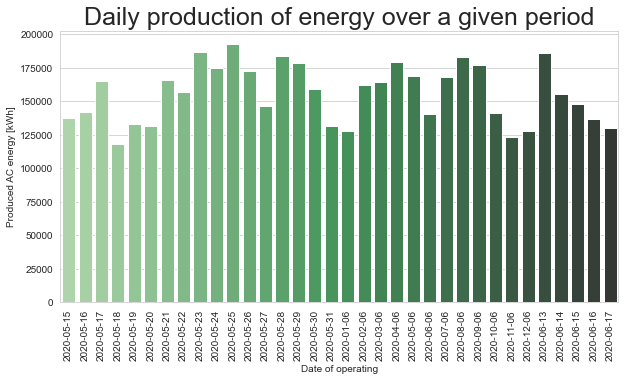

In [7]:
sns.set_style("whitegrid")

fig, total_production = plt.subplots(figsize=(10,5))
total_production = sns.barplot(
    x = "DATE", 
    y = "ENERGY",
    data = sum_gen,
    estimator = sum,
    ci = None,
    palette = "Greens_d"
    )

total_production.set(xlabel='Date of operating', ylabel='Produced AC energy [kWh]')
plt.title('Daily production of energy over a given period', fontsize=25)
plt.xticks(rotation=90)

plt.show()

In the picture above it is visible that everyday's amount of produced energy is diferent. In the next parts of this project I will try to discover reasons of that fact - dependencies of operating on weather conditions.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3264 non-null   datetime64[ns]
 1   PLANT_ID_x           3264 non-null   float64       
 2   DC_POWER             3264 non-null   float64       
 3   AC_POWER             3264 non-null   float64       
 4   DAILY_YIELD          3264 non-null   float64       
 5   TOTAL_YIELD          3264 non-null   float64       
 6   PLANT_ID_y           3264 non-null   float64       
 7   AMBIENT_TEMPERATURE  3264 non-null   float64       
 8   MODULE_TEMPERATURE   3264 non-null   float64       
 9   IRRADIATION          3264 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 255.1 KB


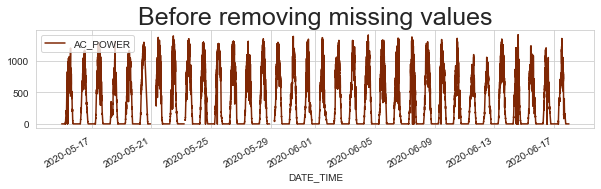

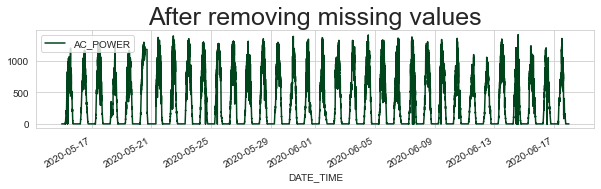

In [11]:
generation['DATE_TIME'] = pd.to_datetime(generation['DATE_TIME'], dayfirst = [False]) #dayfirst solves problem with reading data

to_train = generation.merge(weather, on='DATE_TIME', how='outer', sort=True)

to_train.plot(
    x='DATE_TIME', 
    y='AC_POWER', 
    figsize=(10,2),
    colormap='Oranges_r'
    ) #missing data
plt.title('Before removing missing values', fontsize=25)

periods = (to_train.loc[to_train.index[-1], 'DATE_TIME'] - to_train.loc[0, 'DATE_TIME'])
periods = periods.total_seconds()/(60*15)+1
all_freq = pd.DataFrame(pd.date_range('2020-05-15', periods=periods, freq='15min')) #full time periods
all_freq.columns = ['DATE_TIME']
to_train = all_freq.merge(to_train, how='outer', on='DATE_TIME')
to_train.interpolate(method ='ffill', inplace = True) #filling missing time periods

to_train.plot(
    x='DATE_TIME', 
    y='AC_POWER', 
    figsize=(10,2),
    colormap='Greens_r'
    ) #no missing data

plt.title('After removing missing values', fontsize=25)

to_train = to_train.groupby('DATE_TIME').mean().reset_index() #grouping data by inverters

to_train.info()

In [12]:
to_train.drop(columns=['PLANT_ID_y','PLANT_ID_x'], inplace = True)

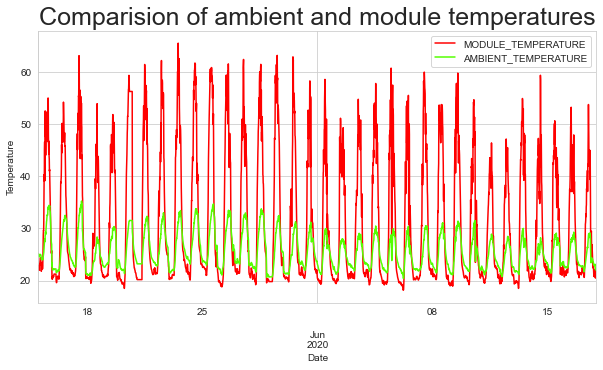

In [13]:
to_train.plot(
    y = ['MODULE_TEMPERATURE','AMBIENT_TEMPERATURE'], 
    x = 'DATE_TIME', 
    figsize=(10,5), 
    xlabel = 'Date', 
    ylabel = 'Temperature',
    colormap = 'prism'
    )

plt.title('Comparision of ambient and module temperatures', fontsize=25)
plt.show()

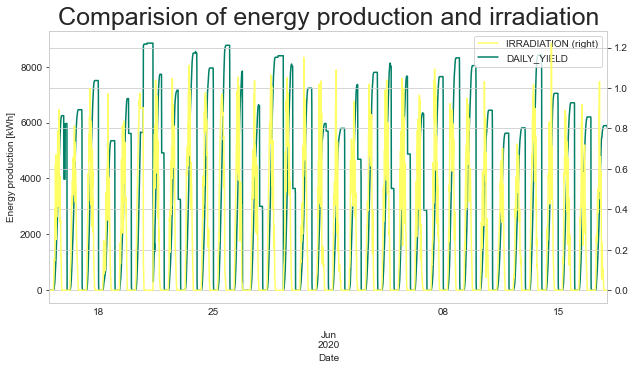

In [14]:
to_train.plot(
    y=['IRRADIATION', 'DAILY_YIELD'], 
    secondary_y = 'IRRADIATION', 
    mark_right = True,  
    x='DATE_TIME',
    figsize=(10,5),
    xlabel='Date',
    ylabel='Energy production [kWh]',
    colormap = 'summer_r'
    )

plt.title('Comparision of energy production and irradiation', fontsize=25)
plt.show()

In [15]:
to_drop = ['DAILY_YIELD', 'TOTAL_YIELD']
kolumny = list(to_train.columns)

for i in to_drop:
    kolumny.remove(i)

to_correlation = to_train[kolumny]
to_correlation

,DATE_TIME,DC_POWER,AC_POWER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,0.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,0.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,0.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,0.0,24.621525,22.165423,0.0
...,...,...,...,...,...,...
3259,2020-06-17 22:45:00,0.0,0.0,22.150570,21.480377,0.0
3260,2020-06-17 23:00:00,0.0,0.0,22.129816,21.389024,0.0
3261,2020-06-17 23:15:00,0.0,0.0,22.008275,20.709211,0.0
3262,2020-06-17 23:30:00,0.0,0.0,21.969495,20.734963,0.0


### Analysis of daily generation

In [16]:
#to_train['DATE'] = to_train['DATE_TIME'].dt.date
#to_train['ENERGY'] = generation['DAILY_YIELD']
#sum_gen = to_train.groupby('DATE').sum().reset_index()
#sum_gen = sum_gen.loc[:, ['DATE', 'ENERGY']]
#to_train

#generate daily production from daily_yield (to repair mean groupby)

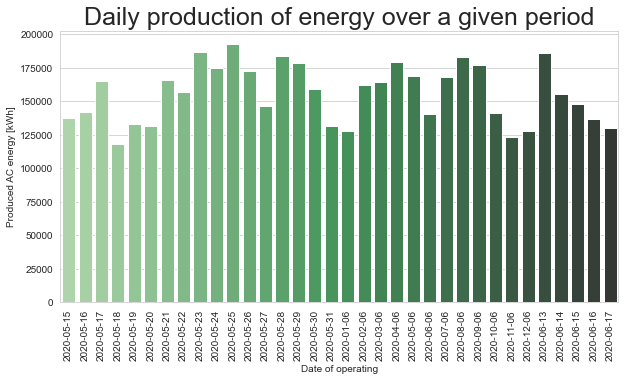

In [17]:
sns.set_style("whitegrid")

fig, total_production = plt.subplots(figsize=(10,5))
total_production = sns.barplot(
    x = "DATE", 
    y = "ENERGY",
    data = sum_gen,
    estimator = sum,
    ci = None,
    palette = "Greens_d"
    )

total_production.set(xlabel='Date of operating', ylabel='Produced AC energy [kWh]')
plt.title('Daily production of energy over a given period', fontsize=25)
plt.xticks(rotation=90)

plt.show()

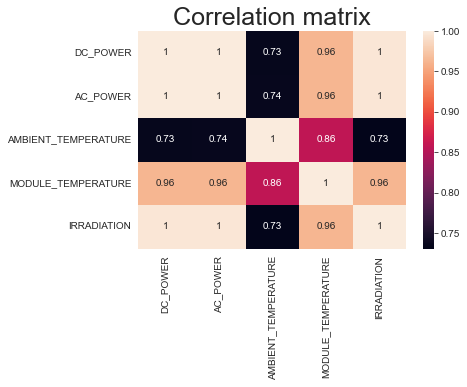

In [18]:
cor_matrix = to_correlation.corr()
sns.heatmap(cor_matrix, annot=True)
plt.title('Correlation matrix', fontsize=25)
fig.set_size_inches(10, 7)
fig.set_dpi(60)
fig.tight_layout()
plt.show()

### PCA implementation

Before applying PCA there is a necessary to standarize values - all of them should be in the same scale. To implement PCA for dimensionality reduction I used only three columns which are predictors needed to estimate energy production.

In [19]:
to_PCA = to_correlation.loc[:,'AMBIENT_TEMPERATURE':'IRRADIATION'] #choosing predictors for energy production
scaling = StandardScaler()
scaled_data = scaling.fit_transform(to_PCA) #standarization of all predictors to PCA

In [20]:
calculating_PCA = PCA(n_components=1)
calculating_PCA.fit(scaled_data)
from_PCA = calculating_PCA.transform(scaled_data)
print('Explained variance ratio: {}'.format(calculating_PCA.explained_variance_ratio_))

Explained variance ratio: [0.9013936]


In [21]:
PCA_to_frame = pd.DataFrame(from_PCA)
timestamp_labels = pd.DataFrame(to_train.loc[:, ['DATE_TIME','AC_POWER']])
dataset_after_PCA = timestamp_labels.merge(PCA_to_frame, left_index=True, right_index=True)
col_names = list(timestamp_labels.columns)
col_names.append('PCA_PREDICTOR')
dataset_after_PCA.columns = col_names
dataset_after_PCA.head(2)

,DATE_TIME,AC_POWER,PCA_PREDICTOR
0,2020-05-15 00:00:00,0.0,-0.885375
1,2020-05-15 00:15:00,0.0,-0.906353


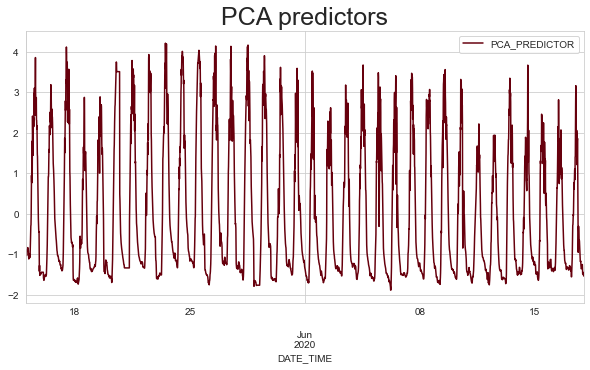

In [22]:
PCA_plot = dataset_after_PCA.plot(
    x='DATE_TIME', 
    y='PCA_PREDICTOR', 
    figsize=(10,5),
    colormap='Reds_r'
    )
plt.title('PCA predictors', fontsize=25)
plt.show()

### Classical decomposition

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

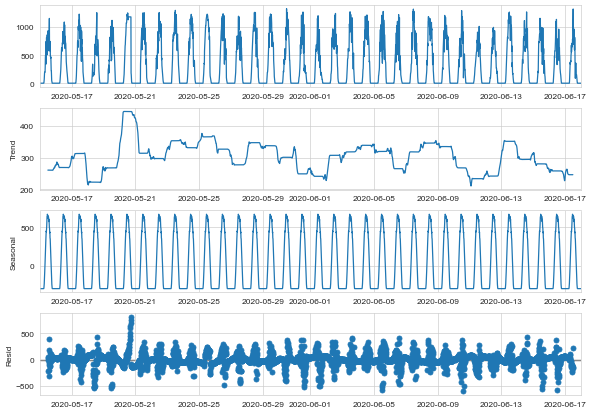

In [24]:
clas_dec = to_train.loc[:, ['DATE_TIME', 'AC_POWER']].set_index('DATE_TIME')
result = seasonal_decompose(clas_dec, period=96)
fig = result.plot()
fig.set_size_inches(10, 7)
fig.set_dpi(60)
fig.tight_layout()
plt.show() #not best performance

### Daily production analysis

In [25]:
#to_train['DATE'] = to_train['DATE_TIME'].dt.date
#to_train['ENERGY'] = to_train['AC_POWER']/4
#sum_gen = to_train.groupby('DATE').sum().reset_index()
#sum_gen = sum_gen.loc[:, ['DATE', 'ENERGY']]
#calculate sum_gen from daily_yield

### ACF and PACF plots

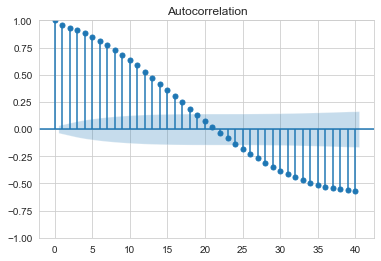

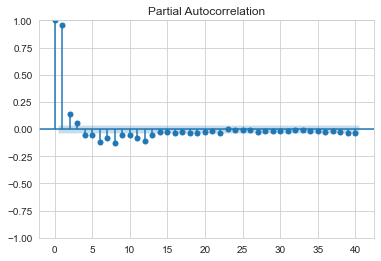

In [34]:
ACF_plot = sm.graphics.tsa.plot_acf(clas_dec, lags=40)
PACF_plot = sm.graphics.tsa.plot_pacf(clas_dec, lags=40, method='ywm')